In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from datetime import datetime

mbb = pd.read_csv('../data/mbb.csv')
mbb['Date'] = pd.to_datetime(mbb['Date'])

In [2]:
mbb.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2022-04-12,8.84,8.89,8.82,8.82,8.82,7898300
1,2022-04-11,8.85,8.89,8.84,8.85,8.85,3598100
2,2022-04-08,8.85,8.86,8.82,8.85,8.85,5400400
3,2022-04-07,8.89,8.89,8.83,8.83,8.83,10373800
4,2022-04-06,8.85,8.94,8.85,8.89,8.89,6850400


### 0. Data Preparation

In [3]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if (df[cols[i]].min() > np.iinfo(np.int8).min) and (df[cols[i]].max() < np.iinfo(np.int8).max):
                df[cols[i]] = df[cols[i]].astype(np.int8)
                
            elif (df[cols[i]].min() > np.iinfo(np.int16).min) and (df[cols[i]].max() < np.iinfo(np.int16).max):
                df[cols[i]] = df[cols[i]].astype(np.int16)
                
            elif (df[cols[i]].min() > np.iinfo(np.int32).min) and (df[cols[i]].max() < np.iinfo(np.int32).max):
                df[cols[i]] = df[cols[i]].astype(np.int32)
            
            else:
                df[cols[i]] = df[cols[i]].asypes(np.int64)
        elif 'float' in str(t):
            if (df[cols[i]].min() > np.finfo(np.float16).min) and (df[cols[i]].max() < np.finfo(np.float16).max):
                df[cols[i]] = df[cols[i]].astype(np.float16)
                
            elif (df[cols[i]].min() > np.finfo(np.float32).min) and (df[cols[i]].max() < np.finfo(np.float32).max):
                df[cols[i]] = df[cols[i]].astype(np.float32)
            
            else:
                df[cols[i]] = df[cols[i]].asypes(np.float64)
        elif t == object:
            if cols[i] == 'date':
                #df[cols[i]] = pd.to_datetime(df[cols[i]], format = '%Y-%m-%d')
                pass
            else:
                #df[cols[i]] = df[cols[i]].astypes('category')
                pass
    return df

In [4]:
#1. Apply downcasting method on dataset
#2. Select the data within the covid period

mbb = downcast(mbb)
mbb = mbb[(mbb['Date'] >= '2020-03-18') & (mbb['Date'] < datetime.today())]
print(mbb.shape)

(508, 7)


In [5]:
#3. Check the column, Close whether it exists 0 or null values
print(mbb[mbb['Close'] == 0])
print(mbb[mbb['Close'].isnull()])

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj_Close, Volume]
Index: []
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj_Close, Volume]
Index: []


In [6]:
mbb = mbb[mbb['Close'] > 0]

### 1. Anomaly Detection - Isolation Forest

In [7]:
mbb_len = mbb.shape[0]

In [8]:
from sklearn.ensemble import IsolationForest

contamination = 0.15
anomaly_model = IsolationForest(n_estimators = 100, contamination = contamination, max_samples = mbb_len, max_features = 6)

In [9]:
%%time

#1. Select the column, Close
#df = mbb[['Open','Close']]
df = mbb[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']]
df.reset_index(drop=True, inplace=True)

#2. Fit the dataset into the isolation forest model
anomaly_model.fit(df)

Wall time: 175 ms


IsolationForest(contamination=0.15, max_features=6, max_samples=508)

In [10]:
#3. Predict the anomaly
pred = pd.Series(anomaly_model.predict(df))
df = df.merge(pred.rename('Anomaly_Flag'), left_index = True, right_index = True)
df

,Open,High,Low,Close,Adj_Close,Volume,Anomaly_Flag
0,8.843750,8.890625,8.820312,8.820312,8.820312,7898300,1
1,8.851562,8.890625,8.843750,8.851562,8.851562,3598100,-1
2,8.851562,8.859375,8.820312,8.851562,8.851562,5400400,-1
3,8.890625,8.890625,8.828125,8.828125,8.828125,10373800,-1
4,8.851562,8.937500,8.851562,8.890625,8.890625,6850400,1
...,...,...,...,...,...,...,...
503,7.199219,7.339844,7.199219,7.300781,6.296875,14441000,-1
504,7.199219,7.320312,7.109375,7.121094,6.144531,18596500,-1
505,7.089844,7.550781,7.078125,7.511719,6.480469,22601000,-1
506,7.191406,7.238281,7.019531,7.078125,6.109375,23988500,-1


In [11]:
date = mbb['Date'].reset_index(drop = True)
df = df.merge(date.rename('Date'), left_index = True, right_index = True)
df

,Open,High,Low,Close,Adj_Close,Volume,Anomaly_Flag,Date
0,8.843750,8.890625,8.820312,8.820312,8.820312,7898300,1,2022-04-12
1,8.851562,8.890625,8.843750,8.851562,8.851562,3598100,-1,2022-04-11
2,8.851562,8.859375,8.820312,8.851562,8.851562,5400400,-1,2022-04-08
3,8.890625,8.890625,8.828125,8.828125,8.828125,10373800,-1,2022-04-07
4,8.851562,8.937500,8.851562,8.890625,8.890625,6850400,1,2022-04-06
...,...,...,...,...,...,...,...,...
503,7.199219,7.339844,7.199219,7.300781,6.296875,14441000,-1,2020-03-24
504,7.199219,7.320312,7.109375,7.121094,6.144531,18596500,-1,2020-03-23
505,7.089844,7.550781,7.078125,7.511719,6.480469,22601000,-1,2020-03-20
506,7.191406,7.238281,7.019531,7.078125,6.109375,23988500,-1,2020-03-19


In [12]:
df = df[['Date','Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'Anomaly_Flag']]
df

,Date,Open,High,Low,Close,Adj_Close,Volume,Anomaly_Flag
0,2022-04-12,8.843750,8.890625,8.820312,8.820312,8.820312,7898300,1
1,2022-04-11,8.851562,8.890625,8.843750,8.851562,8.851562,3598100,-1
2,2022-04-08,8.851562,8.859375,8.820312,8.851562,8.851562,5400400,-1
3,2022-04-07,8.890625,8.890625,8.828125,8.828125,8.828125,10373800,-1
4,2022-04-06,8.851562,8.937500,8.851562,8.890625,8.890625,6850400,1
...,...,...,...,...,...,...,...,...
503,2020-03-24,7.199219,7.339844,7.199219,7.300781,6.296875,14441000,-1
504,2020-03-23,7.199219,7.320312,7.109375,7.121094,6.144531,18596500,-1
505,2020-03-20,7.089844,7.550781,7.078125,7.511719,6.480469,22601000,-1
506,2020-03-19,7.191406,7.238281,7.019531,7.078125,6.109375,23988500,-1


In [13]:
df['Yesterday_Close'] = df['Close'].shift(1)
#df['percentage_change'] = ((df['Close'] - df['shift']) / df['Close']) * 100
df['Percentage_Change'] = ((df['Close'] - df['Yesterday_Close']) / df['Close']) * 100
df['Percentage_Change'] = np.round(df['Percentage_Change'],2)
df

,Date,Open,High,Low,Close,Adj_Close,Volume,Anomaly_Flag,Yesterday_Close,Percentage_Change
0,2022-04-12,8.843750,8.890625,8.820312,8.820312,8.820312,7898300,1,NaN,NaN
1,2022-04-11,8.851562,8.890625,8.843750,8.851562,8.851562,3598100,-1,8.820312,0.350098
2,2022-04-08,8.851562,8.859375,8.820312,8.851562,8.851562,5400400,-1,8.851562,0.000000
3,2022-04-07,8.890625,8.890625,8.828125,8.828125,8.828125,10373800,-1,8.851562,-0.270020
4,2022-04-06,8.851562,8.937500,8.851562,8.890625,8.890625,6850400,1,8.828125,0.700195
...,...,...,...,...,...,...,...,...,...,...
503,2020-03-24,7.199219,7.339844,7.199219,7.300781,6.296875,14441000,-1,7.300781,0.000000
504,2020-03-23,7.199219,7.320312,7.109375,7.121094,6.144531,18596500,-1,7.300781,-2.519531
505,2020-03-20,7.089844,7.550781,7.078125,7.511719,6.480469,22601000,-1,7.121094,5.199219
506,2020-03-19,7.191406,7.238281,7.019531,7.078125,6.109375,23988500,-1,7.511719,-6.121094


In [14]:
df = df.replace(np.nan, 0)

In [ ]:
#df.to_csv('C:/Users/Hoe/Desktop/Learning/Python/Project 9 - Anomaly Detection/data/result.csv')

### 2. Insert into mysql table, anomaly_isolation_mbb

In [ ]:
#df['Date'] = df['Date'].astype('str')
#df_last_row = df.tail(1)
#df_last_row.to_csv('C:/Users/Hoe/Desktop/Learning/Python/Project 9 - Anomaly Detection/data/latest_result.csv', index = False)

In [ ]:
#import csv
#sql_data_list = []
#db_table = 'anomaly_isolation_mbb'
#with open('C:/Users/Hoe/Desktop/Learning/Python/Project 9 - Anomaly Detection/latest_result.csv') as csvfile:
#    csv_data = csv.reader(csvfile, delimiter = ',') #read the csv files
#    next(csv_data, None)  # skip the headers

    #convert the column type from csv files
#    sql_data_list = [] #sql data

#    for df_last_row in csv_data:
#        value = (df_last_row[0], df_last_row[1], df_last_row[2], df_last_row[3], df_last_row[4], df_last_row[5],
#                 df_last_row[6], df_last_row[7], df_last_row[8], df_last_row[9])
#        sql_data_list.append(value)
        
#query = '''
#INSERT INTO anomaly_isolation_mbb
#(Date, Open, High, Low, Close, Adj_Close, Volume, Anomaly_Flag, Yesterday_Close, Percentage_Change) 
#VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
#'''


#cursor.executemany(query, sql_data_list)
#db.commit()

#query = f"INSERT INTO {db_table} (Date, Open, High, Low, Close, Adj_Close, Volume) VALUES(%s, %s, %s, %s, %s, %s, %s)"


### 3. Plot Visualization (Matplotlib)

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

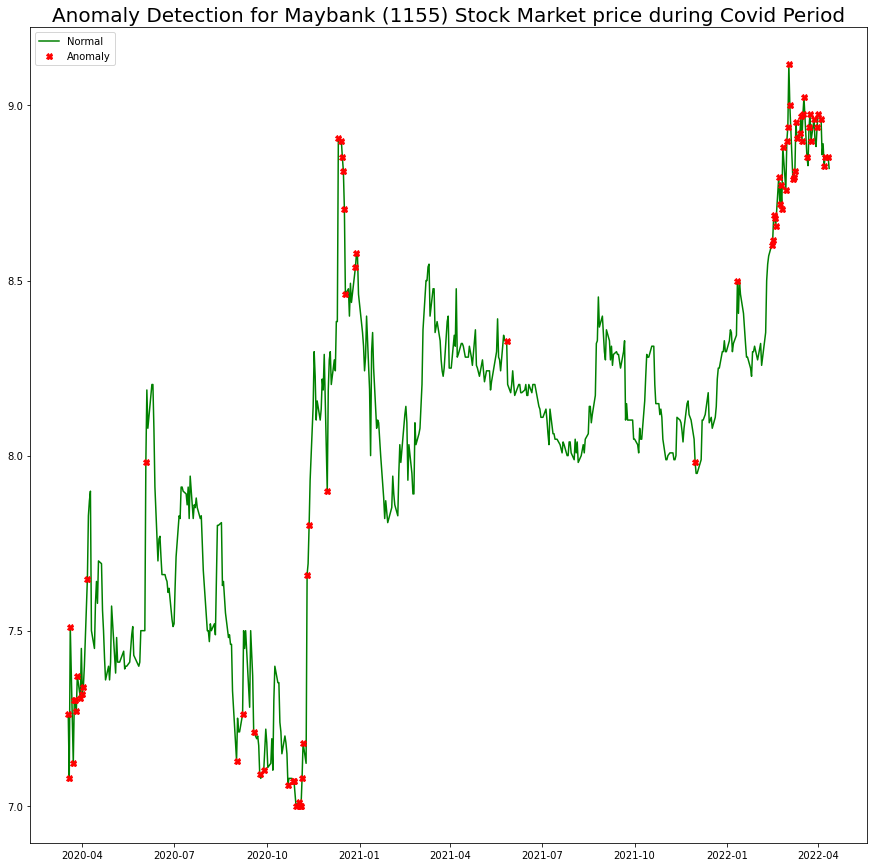

In [16]:
plt.figure(figsize = (15, 15))

test = df.copy()
test.set_index('Date', inplace = True)
anomaly = test[test['Anomaly_Flag'] == -1]


plt.plot(test['Close'], color = 'Green', label = 'Normal')
plt.plot(anomaly['Close'], linestyle = 'none', marker = 'X', color = 'Red', label = 'Anomaly')

plt.title('Anomaly Detection for Maybank (1155) Stock Market price during Covid Period', size = 20)
plt.legend(loc = 'best')
plt.show()